In [11]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("C:\\Users\\lclai\\Desktop\\research LDIG\\data_dementia\\clean\\pitt_clean.csv")
df = df[df["label"].isin([0, 1])]
df["sex"] = df["sex"].map({"M": 0, "F": 1})
df.dropna(subset=["clean_transcripts", "age", "sex"], inplace=True)

clean_text = df["clean_transcripts"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=clean_text, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

def get_word2vec_embedding(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_text_w2v = np.array([get_word2vec_embedding(text, word2vec_model) for text in clean_text])
X_text_df = pd.DataFrame(X_text_w2v, columns=[f'w2v_{i}' for i in range(X_text_w2v.shape[1])])

X_features = df[['sex', 'age']].reset_index(drop=True)
X_full = pd.concat([X_features, X_text_df], axis=1)

y = LabelEncoder().fit_transform(df["label"])

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_train = pd.DataFrame(X_train, columns=X_full.columns)
X_test = pd.DataFrame(X_test, columns=X_full.columns)


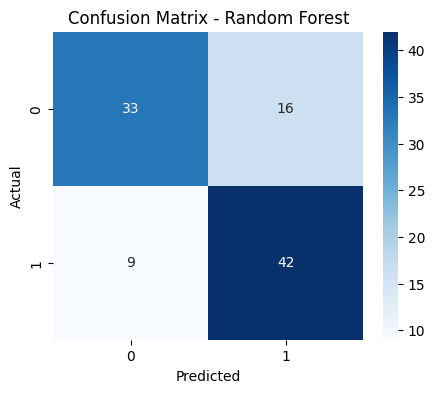

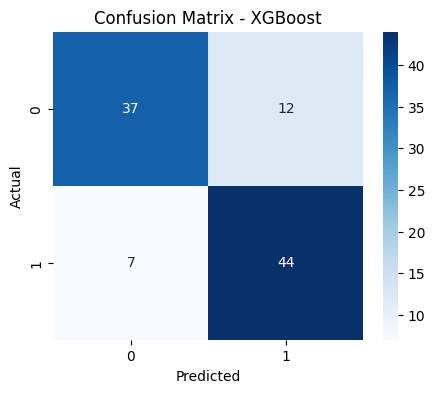

Model: Random Forest
Best Params: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Mean AUC (CV=5): 0.8806
STD AUC (CV=5): 0.0381
AUC on Test Set: 0.8832

Model: XGBoost
Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.8}
Mean AUC (CV=5): 0.8859
STD AUC (CV=5): 0.0377
AUC on Test Set: 0.9076



In [12]:
# random forest and XGB models
# we scale only the age feature --> best results

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

age_column = 'age'
other_columns = [col for col in X_train.columns if col != age_column]

preprocessor = ColumnTransformer(
    transformers=[
        ('age_scaler', StandardScaler(), [age_column])
    ],
    remainder='passthrough'  
)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'Random Forest': {
        'model__n_estimators': [500, 1000],
        'model__max_depth': [None, 2,10],
        'model__min_samples_split': [2,5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'model__n_estimators': [500, 1000],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 6, 10],
        'model__subsample': [0.8, 1.0]
    }
}

results = {}

for model_name in models:
    model = models[model_name]
    param_grid = param_grids[model_name]

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    mean_auc_cv = grid_search.best_score_
    std_auc_cv = grid_search.cv_results_['std_test_score'][grid_search.best_index_]


    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'mean_auc_cv': mean_auc_cv,
        'std_cv': std_auc_cv,
        'auc_test': auc_test,
        'best_model': best_model
    }

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Mean AUC (CV=5): {result['mean_auc_cv']:.4f}")
    print(f"STD AUC (CV=5): {result['std_cv']:.4f}")
    print(f"AUC on Test Set: {result['auc_test']:.4f}\n")


Mean AUC CV (XGBoost): 0.8944
Mean AUC CV (Random Forest): 0.8827
Mean AUC CV (Ensemble XGB+RF): 0.8945
Std AUC CV (Ensemble XGB+RF): 0.0199
AUC on Test Set (Ensemble XGB+RF): 0.8996


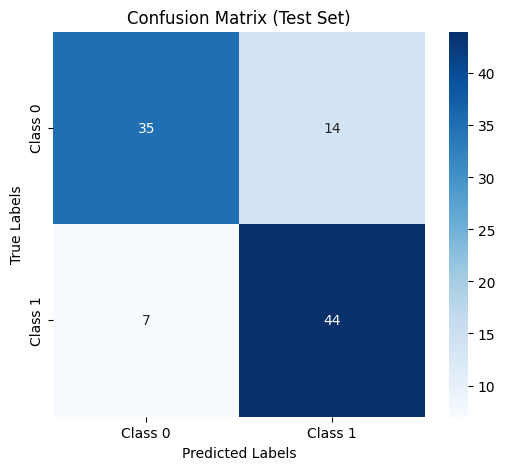

In [13]:
# ensembled model (predictions are made using the mean prob predicted for rf and xgb)

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


age_column = 'age'
other_columns = [col for col in X_train.columns if col != age_column]

# here i take the last paraneters obtained in the previous cell
xgb_clf = xgb.XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.01, subsample=0.8, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features="sqrt", random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_xgb_folds = []
auc_rf_folds = []
auc_ensemble_folds = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]

    preprocessor = ColumnTransformer(
        transformers=[
            ('age_scaler', StandardScaler(), [age_column])
        ],
        remainder='passthrough'
    )

    pipe_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(**xgb_clf.get_params()))
    ])

    pipe_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(**rf_clf.get_params()))
    ])

    pipe_xgb.fit(X_train_fold, y_train_fold)
    pipe_rf.fit(X_train_fold, y_train_fold)

    pred_xgb = pipe_xgb.predict_proba(X_val_fold)[:, 1]
    pred_rf = pipe_rf.predict_proba(X_val_fold)[:, 1]
    pred_ensemble = (pred_xgb + pred_rf) / 2

    auc_xgb_folds.append(roc_auc_score(y_val_fold, pred_xgb))
    auc_rf_folds.append(roc_auc_score(y_val_fold, pred_rf))
    auc_ensemble_folds.append(roc_auc_score(y_val_fold, pred_ensemble))


final_pipe_xgb = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[('age_scaler', StandardScaler(), [age_column])],
        remainder='passthrough'
    )),
    ('model', xgb_clf)
])

final_pipe_rf = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[('age_scaler', StandardScaler(), [age_column])],
        remainder='passthrough'
    )),
    ('model', rf_clf)
])

final_pipe_xgb.fit(X_train, y_train)
final_pipe_rf.fit(X_train, y_train)

pred_xgb = final_pipe_xgb.predict_proba(X_test)[:, 1]
pred_rf = final_pipe_rf.predict_proba(X_test)[:, 1]
pred_ensemble = (pred_xgb + pred_rf) / 2

auc_test = roc_auc_score(y_test, pred_ensemble)
y_pred_final = (pred_ensemble >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_final)

print(f"Mean AUC CV (XGBoost): {np.mean(auc_xgb_folds):.4f}")
print(f"Mean AUC CV (Random Forest): {np.mean(auc_rf_folds):.4f}")
print(f"Mean AUC CV (Ensemble XGB+RF): {np.mean(auc_ensemble_folds):.4f}")
print(f"Std AUC CV (Ensemble XGB+RF): {np.std(auc_ensemble_folds):.4f}")
print(f"AUC on Test Set (Ensemble XGB+RF): {auc_test:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

age_column = 'age'
other_columns = [col for col in X_train.columns if col != age_column]

preprocessor = ColumnTransformer(
    transformers=[
        ('age_scaler', StandardScaler(), [age_column])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__max_iter': [100, 200, 500]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score (CV AUC): {grid_search.best_score_:.4f}")
print(f'STD AUC CV: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]}')
print(f"AUC en Test Set: {auc:.4f}")


Mejores parámetros: {'classifier__C': 10, 'classifier__max_iter': 100}
Mejor score (CV AUC): 0.8971
STD AUC CV: 0.029986599591091533
AUC en Test Set: 0.9512
